In [1]:
import torch.nn as nn
import torch
import torch.nn.functional as f


class RNN(nn.Module):
    def __init__(self, input_shape, args):
        super(RNN, self).__init__()
        self.args = args

        self.fc1 = nn.Linear(input_shape, args.rnn_hidden_dim)
        self.rnn = nn.GRUCell(args.rnn_hidden_dim, args.rnn_hidden_dim)
        self.fc2 = nn.Linear(args.rnn_hidden_dim, args.num_actions)

    def forward(self, obs, hidden_state):
        x = f.relu(self.fc1(obs))
        h_in = hidden_state.reshape(-1, self.args.rnn_hidden_dim)
        h = self.rnn(x, h_in)
        q = self.fc2(h)
        return q, h


class QMixNet(nn.Module):
    def __init__(self, args):
        super(QMixNet, self).__init__()
        self.args = args

        if args.two_hyper_layers:
            self.hyper_w1 = nn.Sequential(nn.Linear(args.state_shape, args.hyper_hidden_dim),
                                          nn.ReLU(),
                                          nn.Linear(args.hyper_hidden_dim, args.n_agents * args.qmix_hidden_dim))
            self.hyper_w2 = nn.Sequential(nn.Linear(args.state_shape, args.hyper_hidden_dim),
                                          nn.ReLU(),
                                          nn.Linear(args.hyper_hidden_dim, args.qmix_hidden_dim))
        else:
            self.hyper_w1 = nn.Linear(args.state_space, args.num_agents * args.qmix_hidden_dim)
            self.hyper_w2 = nn.Linear(args.state_space, args.qmix_hidden_dim * 1)

        self.hyper_b1 = nn.Linear(args.state_space, args.qmix_hidden_dim)
        self.hyper_b2 =nn.Sequential(nn.Linear(args.state_space, args.qmix_hidden_dim),
                                     nn.ReLU(),
                                     nn.Linear(args.qmix_hidden_dim, 1))

    def forward(self, q_values, states):
        episode_num = q_values.size(0)
        q_values = q_values.view(-1, 1, self.args.num_agents)
        states = states.reshape(-1, self.args.state_space)

        w1 = torch.abs(self.hyper_w1(states))
        b1 = self.hyper_b1(states)

        w1 = w1.view(-1, self.args.num_agents, self.args.qmix_hidden_dim)
        b1 = b1.view(-1, 1, self.args.qmix_hidden_dim)

        hidden = f.elu(torch.bmm(q_values, w1) + b1)

        w2 = torch.abs(self.hyper_w2(states))
        b2 = self.hyper_b2(states)

        w2 = w2.view(-1, self.args.qmix_hidden_dim, 1)
        b2 = b2.view(-1, 1, 1)

        q_total = torch.bmm(hidden, w2) + b2
        q_total = q_total.view(episode_num, -1, 1)
        return q_total


In [2]:
class QMIX:
    def __init__(self, args):
        self.num_actions = args.num_actions
        self.num_agents = args.num_agents
        self.state_space = args.state_space
        self.obs_space = args.obs_space
        input_shape = self.obs_space
        if args.last_action:
            input_shape += self.num_actions
        if args.reuse_network:
            input_shape += self.num_agents

        self.eval_rnn = RNN(input_shape, args)
        self.target_rnn = RNN(input_shape, args)
        self.eval_qmix_net = QMixNet(args)
        self.target_qmix_net = QMixNet(args)
        self.args = args
        if self.args.cuda:
            self.eval_rnn.cuda()
            self.target_rnn.cuda()
            self.eval_qmix_net.cuda()
            self.target_qmix_net.cuda()
#         self.model_dir = args.model_dir + '/' + args.alg + '/' + args.map

        if self.args.load_model:
            if os.path.exists(self.model_dir + '/rnn_net_params.pkl'):
                path_rnn = self.model_dir + '/rnn_net_params.pkl'
                path_qmix = self.model_dir + '/qmix_net_params.pkl'
                self.eval_rnn.load_state_dict(torch.load(path_rnn))
                self.eval_qmix_net.load_state_dict(torch.load(path_qmix))
                print('Successfully load the model: {} and {}'.format(path_rnn, path_qmix))
            else:
                raise Exception("No model!")

        self.target_rnn.load_state_dict(self.eval_rnn.state_dict())
        self.target_qmix_net.load_state_dict(self.eval_qmix_net.state_dict())

        self.eval_parameters = list(self.eval_qmix_net.parameters()) + list(self.eval_rnn.parameters())
        if args.optimizer == "RMS":
            self.optimizer = torch.optim.RMSprop(self.eval_parameters, lr=args.lr)

        self.eval_hidden = None
        self.target_hidden = None
        print('Init QMIX')

    def learn(self, batch, max_episode_len, train_step, epsilon=None):  # train_step表示是第几次学习，用来控制更新target_net网络的参数
        episode_num = batch['o'].shape[0]
        self.init_hidden(episode_num)
        for key in batch.keys():
            if key == 'u':
                batch[key] = torch.tensor(batch[key], dtype=torch.long)
            else:
                batch[key] = torch.tensor(batch[key], dtype=torch.float32)
        s, s_next, u, r, avail_u, avail_u_next, terminated = batch['s'], batch['s_next'], batch['u'], \
                                                             batch['r'],  batch['avail_u'], batch['avail_u_next'],\
                                                             batch['terminated']
        mask = 1 - batch["padded"].float()

        q_evals, q_targets = self.get_q_values(batch, max_episode_len)
        if self.args.cuda:
            s = s.cuda()
            u = u.cuda()
            r = r.cuda()
            s_next = s_next.cuda()
            terminated = terminated.cuda()
            mask = mask.cuda()
        q_evals = torch.gather(q_evals, dim=3, index=u).squeeze(3)

        q_targets[avail_u_next == 0.0] = - 9999999
        q_targets = q_targets.max(dim=3)[0]

        q_total_eval = self.eval_qmix_net(q_evals, s)
        q_total_target = self.target_qmix_net(q_targets, s_next)
        
#         print(q_total_eval)
#         print(q_total_target)
#         print(terminated)
        targets = r + self.args.gamma * q_total_target * (1 - terminated)

        td_error = (q_total_eval - targets.detach())
        masked_td_error = mask * td_error  # 抹掉填充的经验的td_error
        
#         print(masked_td_error)
        # loss = masked_td_error.pow(2).mean()
        # 쓸모없는 경험이 여전히 많기 때문에 평균을 직접 사용할 수 없으므로 실제 평균은 필수이며 실제 경험입니다.
        loss = (masked_td_error ** 2).sum() / mask.sum()
        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.eval_parameters, self.args.grad_norm_clip)
        self.optimizer.step()

        if train_step > 0 and train_step % self.args.target_update_cycle == 0:
            self.target_rnn.load_state_dict(self.eval_rnn.state_dict())
            self.target_qmix_net.load_state_dict(self.eval_qmix_net.state_dict())

    def _get_inputs(self, batch, transition_idx):
        obs, obs_next, u_onehot = batch['o'][:, transition_idx], \
                                  batch['o_next'][:, transition_idx], batch['u_onehot'][:]
        episode_num = obs.shape[0]
        inputs, inputs_next = [], []
        inputs.append(obs)
        inputs_next.append(obs_next)

        if self.args.last_action:
            if transition_idx == 0:  # 첫 경험이라면, 이전 행동을 0 벡터로하십시오
                inputs.append(torch.zeros_like(u_onehot[:, transition_idx]))
            else:
                inputs.append(u_onehot[:, transition_idx - 1])
            inputs_next.append(u_onehot[:, transition_idx])
        if self.args.reuse_network:
            # 현재 obs 3 차원 데이터에서 각 차원은 (에피소드 수, 에이전트 수, obs 차원)을 나타내므로 해당 벡터를 dim_1에 직접 추가하십시오.
            # 예를 들어 agent_0 뒤에 (1, 0, 0, 0, 0) 만 추가하십시오.
            # 5 개의 에이전트에서 숫자 0을 의미합니다. agent_0의 데이터는 0 번째 행에 있으므로 추가해야합니다.
            # 상담원 번호는 항등 행렬입니다. 즉, 대각선은 1이고 나머지는 0입니다.
            inputs.append(torch.eye(self.args.num_agents).unsqueeze(0).expand(episode_num, -1, -1)  )
            inputs_next.append(torch.eye(self.args.num_agents).unsqueeze(0).expand(episode_num, -1, -1))
        # obs 중 3 개와 episode_num, episode, self.args.n_agents 에이전트의 데이터를 40 개 (40,96)의 데이터로 결합하려면,
        # 여기에있는 모든 에이전트는 신경망을 공유하므로 각 데이터에는 고유 번호가 수반되므로 여전히 자체 데이터입니다
        inputs = torch.cat([x.reshape(episode_num * self.args.num_agents, -1) for x in inputs], dim=1)
        inputs_next = torch.cat([x.reshape(episode_num * self.args.num_agents, -1) for x in inputs_next], dim=1)
        return inputs, inputs_next

    def get_q_values(self, batch, max_episode_len):
        episode_num = batch['o'].shape[0]
        q_evals, q_targets = [], []
        for transition_idx in range(max_episode_len):
            inputs, inputs_next = self._get_inputs(batch, transition_idx)
            if self.args.cuda:
                inputs = inputs.cuda()
                inputs_next = inputs_next.cuda()
                self.eval_hidden = self.eval_hidden.cuda()
                self.target_hidden = self.target_hidden.cuda()
            q_eval, self.eval_hidden = self.eval_rnn(inputs, self.eval_hidden)
            q_target, self.target_hidden = self.target_rnn(inputs_next, self.target_hidden)

            # 把q_eval维度重新变回(8, ,num_actions)
            q_eval = q_eval.view(episode_num, self.num_agents, -1)
            q_target = q_target.view(episode_num, self.num_agents, -1)
            q_evals.append(q_eval)
            q_targets.append(q_target)
        q_evals = torch.stack(q_evals, dim=1)
        q_targets = torch.stack(q_targets, dim=1)
        return q_evals, q_targets

    def init_hidden(self, episode_num):
        self.eval_hidden = torch.zeros((episode_num, self.num_agents, self.args.rnn_hidden_dim)) ###
        self.target_hidden = torch.zeros((episode_num, self.num_agents, self.args.rnn_hidden_dim))

    def save_model(self, train_step):
        num = str(train_step // self.args.save_cycle)
        if not os.path.exists(self.model_dir):
            os.makedirs(self.model_dir)
        torch.save(self.eval_qmix_net.state_dict(), self.model_dir + '/' + num + '_qmix_net_params.pkl')
        torch.save(self.eval_rnn.state_dict(),  self.model_dir + '/' + num + '_rnn_net_params.pkl')


In [3]:
class Agents:
    def __init__(self, args):
        self.num_actions = args.num_actions
        self.num_agents = args.num_agents
        self.state_space = args.state_space
        self.obs_space = args.obs_space
        self.policy = QMIX(args)
        self.args = args

    def choose_action(self, obs, last_action, agent_num, avail_actions, epsilon, evaluate=False):
        inputs = obs.copy()
        avail_actions_ind = np.nonzero(avail_actions)[0]

        agent_id = np.zeros(self.num_agents)
        agent_id[agent_num] = 1.

        if self.args.last_action:
            inputs = np.hstack((inputs, last_action))

        if self.args.reuse_network:
            inputs = np.hstack((inputs, agent_id))

        hidden_state = self.policy.eval_hidden[:, agent_num, :]
        inputs = torch.tensor(inputs, dtype=torch.float32).unsqueeze(0)
        # avail_actions =torch. tensor(avail_actions, dtype=torch.float32).unsqueeze(0)

        if self.args.cuda:
            inputs = inputs.cuda()
            hidden_state = hidden_state.cuda()

        q_value, self.policy.eval_hidden[:, agent_num, :] = self.policy.eval_rnn(inputs, hidden_state)

        # q_value[avail_actions == 0.0] = -float("inf")
        if np.random.uniform() < epsilon:
            # action = np.random.choice(avail_actions_ind)
            action = np.random.choice(self.args.num_actions)
        else:
            action = torch.argmax(q_value)
#             print(action)
        return action

    def _get_max_episode_len(self, batch):
        terminated = batch['terminated']
        episode_num = terminated.shape[0]
#         print(episode_num)
        max_episode_len = 0

        for episode_idx in range(episode_num):
            for transition_idx in range(self.args.max_episode_steps):
                if transition_idx + 1 >= max_episode_len:
                    max_episode_len = transition_idx + 1
                break

        return max_episode_len

    def train(self, batch, train_step, epsilon=None):
        max_episdoe_len = self._get_max_episode_len(batch)

        for key in batch.keys():
            batch[key] = batch[key][:,:max_episdoe_len]

        self.policy.learn(batch, max_episdoe_len, train_step, epsilon)

#         if train_step > 0 and train_step % self.args.save_cycle == 0:
#             self.policy.save_model(train_step)

# from gym.core import Env
import argparse
import numpy as np


def qmix_args(args):
    args.rnn_hidden_dim = 64                #64
    args.two_hyper_layers = False
    args.qmix_hidden_dim = 32               #32
    args.lr = 1e-4

    # epsilon greedy
    args.epsilon = 1                        #1
    args.min_epsilon = 0.05                 #0.05
    anneal_steps = 200                      #200
    args.anneal_epsilon = (args.epsilon - args.min_epsilon) / anneal_steps
    args.epsilon_anneal_scale = 'step'

    # the number of the epoch to train the agent
    args.n_epoch = 10000

    # the number of the episodes in one epoch
    args.n_episodes = 1

    # the number of the train steps in one epoch
    args.train_steps = 3

    # # how often to evaluate
    args.evaluate_cycle = 100

    # experience replay
    args.batch_size = 64
    args.buffer_size = 100

    # how often to save the model
    args.save_cycle = 5000

    # how often to update the target_net
    args.target_update_cycle = 200

    # prevent gradient explosion
    args.grad_norm_clip = 10

    return args


def get_common_args():
    parser = argparse.ArgumentParser()

    # the environment setting
    parser.add_argument('--obs_space', type=int, default=2, help='observation space')
    parser.add_argument('--state_space', type=int, default=4, help='observation space')

    parser.add_argument('--action_space', type=int, default=1, help='action space')
    parser.add_argument('--num_actions', type=int, default=5, help='number of actions')
    parser.add_argument('--num_agents', type=int, default=2, help='number of agents')
    parser.add_argument('--max_episode_steps', type=int, default=100, help='number of agents')

#     parser.add_argument('--difficulty', type=str, default='7', help='the difficulty of the game')
#     parser.add_argument('--game_version', type=str, default='latest', help='the version of the game')
#     parser.add_argument('--map', type=str, default='3m', help='the map of the game')
    parser.add_argument('--seed', type=int, default=123, help='random seed')
    parser.add_argument('--step_mul', type=int, default=8, help='how many steps to make an action')
    parser.add_argument('--replay_dir', type=str, default='', help='the directory of save the replay')

    parser.add_argument('--alg', type=str, default='qmix', help='the algorithm to train the agent')
    parser.add_argument('--last_action', type=bool, default=True, help='whether to use the last action to choose action')
    parser.add_argument('--reuse_network', type=bool, default=True, help='whether to use one network for all agents')
    parser.add_argument('--gamma', type=float, default=0.99, help='discount factor')
    parser.add_argument('--optimizer', type=str, default="RMS", help='optimizer')
    parser.add_argument('--n_evaluate_episode', type=int, default=1, help='number of the episode to evaluate the agent')
    parser.add_argument('--model_dir', type=str, default='./model', help='model directory of the policy')
    parser.add_argument('--result_dir', type=str, default='./result', help='result directory of the policy')
    parser.add_argument('--load_model', type=bool, default=False, help='whether to load the pretrained model')
    parser.add_argument('--learn', type=bool, default=True, help='whether to train the model')
    parser.add_argument('--cuda', type=bool, default=False, help='whether to use the GPU')
    parser.add_argument('--threshold', type=float, default=19.9, help='threshold to judge whether win')
    args = parser.parse_args([])
    return args

In [4]:
from gym.core import Env

import argparse 
import numpy as np

def qmix_args(args): 
    args.rnn_hidden_dim = 128 #64 
    args.two_hyper_layers = False 
    args.qmix_hidden_dim = 64 #32 
    args.lr = 1e-3            #0.001

    # epsilon greedy
    args.epsilon = 1                        #1
    args.min_epsilon = 0.05                 #0.05
    anneal_steps = 200                      #200
    args.anneal_epsilon = (args.epsilon - args.min_epsilon) / anneal_steps
    args.epsilon_anneal_scale = 'step'

    # the number of the epoch to train the agent
    args.n_epoch = 10000

    # the number of the episodes in one epoch
    args.n_episodes = 1

    # the number of the train steps in one epoch
    args.train_steps = 1

    # # how often to evaluate
    args.evaluate_cycle = 1

    # experience replay
    args.batch_size = 64      #64
    args.buffer_size = 100    #100

    # how often to save the model
    args.save_cycle = 5000

    # how often to update the target_net
    args.target_update_cycle = 200       #200

    # prevent gradient explosion
    args.grad_norm_clip = 10

    return args

def get_common_args(): 
    parser = argparse.ArgumentParser()

    # the environment setting
    parser.add_argument('--obs_space', type=int, default=2, help='observation space')
    parser.add_argument('--state_space', type=int, default=4, help='observation space')

    parser.add_argument('--action_space', type=int, default=1, help='action space')
    parser.add_argument('--num_actions', type=int, default=5, help='number of actions')
    parser.add_argument('--num_agents', type=int, default=2, help='number of agents')
    parser.add_argument('--max_episode_steps', type=int, default=50, help='number of agents')

#     parser.add_argument('--difficulty', type=str, default='7', help='the difficulty of the game')
#     parser.add_argument('--game_version', type=str, default='latest', help='the version of the game')
#     parser.add_argument('--map', type=str, default='3m', help='the map of the game')

    parser.add_argument('--seed', type=int, default=1, help='random seed')
    parser.add_argument('--step_mul', type=int, default=1, help='how many steps to make an action')
    parser.add_argument('--replay_dir', type=str, default='', help='the directory of save the replay')

    parser.add_argument('--alg', type=str, default='qmix', help='the algorithm to train the agent')
    parser.add_argument('--last_action', type=bool, default=True, help='whether to use the last action to choose action')
    parser.add_argument('--reuse_network', type=bool, default=True, help='whether to use one network for all agents')
    parser.add_argument('--gamma', type=float, default=0.99, help='discount factor')
    parser.add_argument('--optimizer', type=str, default="RMS", help='optimizer')
    parser.add_argument('--n_evaluate_episode', type=int, default=1, help='number of the episode to evaluate the agent')
    parser.add_argument('--model_dir', type=str, default='./model', help='model directory of the policy')
    parser.add_argument('--result_dir', type=str, default='./result', help='result directory of the policy')
    parser.add_argument('--load_model', type=bool, default=False, help='whether to load the pretrained model')
    parser.add_argument('--learn', type=bool, default=True, help='whether to train the model')
    parser.add_argument('--cuda', type=bool, default=False, help='whether to use the GPU')
    parser.add_argument('--threshold', type=float, default=19.9, help='threshold to judge whether win')
    args = parser.parse_args([])
    return args

In [5]:
import threading


class ReplayBuffer:
    def __init__(self, args):
        self.args = args
        self.num_actions = self.args.num_actions
        self.num_agents = self.args.num_agents
        self.state_space = self.args.state_space
        self.obs_space = self.args.obs_space
        self.size = self.args.buffer_size
        self.episode_limit = self.args.max_episode_steps

        self.current_idx = 0
        self.current_size = 0

        self.buffers = {'o': np.empty([self.size, self.episode_limit, self.num_agents, self.obs_space]),
                        'u': np.empty([self.size, self.episode_limit, self.num_agents, 1]),
                        's': np.empty([self.size, self.episode_limit, self.state_space]),
                        'r': np.empty([self.size, self.episode_limit, 1]),
                        'o_next': np.empty([self.size, self.episode_limit, self.num_agents, self.obs_space]),
                        's_next': np.empty([self.size, self.episode_limit, self.state_space]),
                        'avail_u': np.empty([self.size, self.episode_limit, self.num_agents, self.num_actions]),
                        'avail_u_next': np.empty([self.size, self.episode_limit, self.num_agents, self.num_actions]),
                        'u_onehot': np.empty([self.size, self.episode_limit, self.num_agents, self.num_actions]),
                        'padded': np.empty([self.size, self.episode_limit, 1]),
                        'terminated': np.empty([self.size, self.episode_limit, 1])
                        }
        self.lock = threading.Lock()

    def store_episode(self, episode_batch):
        batch_size = episode_batch['o'].shape[0]
        with self.lock:
            idxs = self._get_storage_idx(inc=batch_size)

            # store the informations
            self.buffers['o'][idxs] = episode_batch['o']
            self.buffers['u'][idxs] = episode_batch['u']
            self.buffers['s'][idxs] = episode_batch['s']
            self.buffers['r'][idxs] = episode_batch['r']
            self.buffers['o_next'][idxs] = episode_batch['o_next']
            self.buffers['s_next'][idxs] = episode_batch['s_next']
            self.buffers['u_onehot'][idxs] = episode_batch['u_onehot']
            self.buffers['padded'][idxs] = episode_batch['padded']
            self.buffers['terminated'][idxs] = episode_batch['terminated']

    def sample(self, batch_size):
        temp_buffer = {}
        idx = np.random.randint(0, self.current_size, batch_size)
        for key in self.buffers.keys():
            temp_buffer[key] = self.buffers[key][idx]
        return temp_buffer

    def _get_storage_idx(self, inc=None):
        inc = inc or 1
        if self.current_idx + inc <= self.size:
            idx = np.arange(self.current_idx, self.current_idx + inc)
            self.current_idx += inc
        elif self.current_idx < self.size:
            overflow = inc - (self.size - self.current_idx)
            idx_a = np.arange(self.current_idx, self.size)
            idx_b = np.arange(0, overflow)
            idx = np.concatenate([idx_a, idx_b])
            self.current_idx = overflow
        else:
            idx = np.arange(0, inc)
            self.current_idx = inc

        self.current_size = min(self.size, self.current_size + inc)

        if inc == 1:
            idx = idx[0]

        return idx

In [6]:
class RolloutWorker:
    def __init__(self, env, agents, args):
        self.env = env
        self.agents = agents
        # self.episode_limit = args.episode_limit
        self.num_actions = args.num_actions
        self.num_agents = args.num_agents
        self.state_space = args.state_space
        self.obs_space = args.obs_space
        self.args = args

        self.epsilon = args.epsilon
        self.anneal_epsilon = args.anneal_epsilon
        self.min_epsilon = args.min_epsilon
#         self.env.reset()
        print('init rollout worker')

    def generate_episode(self, episode_num=None, evaluate=False):
        o, u, r, s, avail_u, u_onehot, terminate, padded = [], [], [], [], [], [], [], []
        self.env.reset()
        
        done_n = [False for _ in range(self.args.num_agents)]
        terminated = False
        step = 0
        episode_reward = 0

        last_action = np.zeros((self.args.num_agents, self.args.num_actions))
        self.agents.policy.init_hidden(1)


        #epsilon
        epsilon = 0 if evaluate else self.epsilon
        if self.args.epsilon_anneal_scale == 'episode':
            epsilon = epsilon - self.anneal_epsilon if epsilon > self.min_epsilon else epsilon
        if self.args.epsilon_anneal_scale == 'epoch':
            if episode_num == 0:
                epsilon = epsilon - self.anneal_epsilon if epsilon > self.min_epsilon else epsilon
        
        obs = self.env.get_agent_obs()
        state = np.array(obs)
        state = state.reshape([1,-1]).squeeze()
        
        while not terminated:
            # time.sleep(0.2)
#             print(terminated)
            """
            State and Observations
            At each timestep, agents receive local observations drawn within their field of view. This encompasses information about the map within a circular area around each unit and with a radius equal to the sight range. The sight range makes the environment partially observable from the standpoint of each agent. Agents can only observe other agents if they are both alive and located within the sight range. Hence, there is no way for agents to determine whether their teammates are far away or dead.
            
            The feature vector observed by each agent contains the following attributes for both allied and enemy units within the sight range: distance, relative x, relative y, health, shield, and unit_type 1. Shields serve as an additional source of protection that needs to be removed before any damage can be done to the health of units. All Protos units have shields, which can regenerate if no new damage is dealt (units of the other two races do not have this attribute). In addition, agents have access to the last actions of allied units that are in the field of view. Lastly, agents can observe the terrain features surrounding them; particularly, the values of eight points at a fixed radius indicating height and walkability.
            
            The global state, which is only available to agents during centralised training, contains information about all units on the map. Specifically, the state vector includes the coordinates of all agents relative to the centre of the map, together with unit features present in the observations. Additionally, the state stores the energy of Medivacs and cooldown of the rest of allied units, which represents the minimum delay between attacks. Finally, the last actions of all agents are attached to the central state.
            
            All features, both in the state as well as in the observations of individual agents, are normalised by their maximum values. The sight range is set to 9 for all agents.
            """
            actions, avail_actions, actions_onehot = [], [], []
            for agent_id in range(self.num_agents):
                # avail_action = self.env.get_avail_agent_actions(agent_id)
                avail_action = None
                action = self.agents.choose_action(obs[agent_id], last_action[agent_id], agent_id, avail_action, epsilon, evaluate)
                
#                 if self.env._agent_dones(agent_id):
#                 if done_n[agent_id]== True and reward[agent_id]==5:
#                     print(done_n)
#                     action = 4
                action_onehot = np.zeros(self.args.num_actions)
                action_onehot[action] = 1
                actions.append(action)
                if done_n[agent_id]== True and reward[agent_id]==5:
                    print(actions)
                    print(reward)
                actions_onehot.append(action_onehot)
                # avail_actions.append(avail_action)
                last_action[agent_id] = action_onehot
#             print(actions)
            obs, reward, done_n, _ = env.step(actions)
            state = np.array(obs)
            state = state.reshape([1,-1]).squeeze()
            if step == self.args.max_episode_steps - 1:
                terminated = 1
            
            o.append(obs)
            s.append(state)
            u.append(np.reshape(actions, [self.num_agents, 1]))
            u_onehot.append(actions_onehot)
            # avail_u.append(avail_actions)
            reward_sum = np.array(reward).sum()
            r.append(reward_sum)
            if not all(done_n):
                
                terminated = 0
                
            elif all(done_n): 
                terminated = 1
#                 self.env.close()
            terminate.append([terminated])
            padded.append([0.])
#             episode_reward = np.array(reward_sum).sum()
            episode_reward += reward_sum
            step += 1
            # if terminated:
            #     time.sleep(1)
            if self.args.epsilon_anneal_scale == 'step':
                epsilon = epsilon - self.anneal_epsilon if epsilon > self.min_epsilon else epsilon
        print(episode_reward)
        o.append(obs)
#         print(o)
        s.append(state)
        o_next = o[1:]
#         print(o_next)
        s_next = s[1:]
        o = o[:-1]
        s = s[:-1]

        # 最后一个obs需要单独计算一下avail_action，到时候需要计算target_q
        # avail_actions = []
        # for agent_id in range(self.num_agents):
            # avail_action = self.env.get_avail_agent_actions(agent_id)
            # avail_actions.append(avail_action)
        # avail_u.append(avail_actions)
        # avail_u_next = avail_u[1:]
        # avail_u = avail_u[:-1]

        for i in range(step, self.args.max_episode_steps):  # 没有的字段用0填充，并且padded为1
            o.append(np.zeros((self.num_agents, self.obs_space)))
            u.append(np.zeros([self.num_agents, 1]))
            s.append(np.zeros(self.state_space))
            r.append([0.])
            o_next.append(np.zeros((self.num_agents, self.obs_space)))
            s_next.append(np.zeros(self.state_space))
            u_onehot.append(np.zeros((self.num_agents, self.num_actions)))
            # avail_u.append(np.zeros((self.n_agents, self.n_actions)))
            # avail_u_next.append(np.zeros((self.n_agents, self.n_actions)))
            padded.append([1.])
            terminate.append([1.])
        
#         print(u)
#         print(r)
#         print(terminate)
        '''
        (o[n], u[n], r[n], o_next[n], avail_u[n], u_onehot[n])组成第n条经验，各项维度都为(episode数，transition数，n_agents, 自己的具体维度)
         因为avail_u表示当前经验的obs可执行的动作，但是计算target_q的时候，需要obs_net及其可执行动作，
        '''
        episode = dict(o=o.copy(),
                       s=s.copy(),
                       u=u.copy(),
                       r=r.copy(),
                       avail_u=avail_u.copy(),
                       o_next=o_next.copy(),
                       s_next=s_next.copy(),
                       # avail_u_next=avail_u_next.copy(),
                       u_onehot=u_onehot.copy(),
                       padded=padded.copy(),
                       terminated=terminate.copy()
                       )

        for key in episode.keys():
            episode[key] = np.array([episode[key]])
        if not evaluate:
            self.epsilon = epsilon

        return episode, episode_reward

In [7]:
import numpy as np

import gym
from ma_gym.wrappers import Monitor

import matplotlib.pyplot as plt

def show_video():
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                    loop controls style="height: 400px;">
                    <source src="data:video/mp4;base64,{0}" type="video/mp4" />
                 </video>'''.format(encoded.decode('ascii'))))
    else: 
        print("Could not find video")
    

def wrap_env(env):
    env = Monitor(env, './video', force=True)
    return env

args = get_common_args()
args = qmix_args(args)

env = wrap_env(gym.make("Switch2-v0"))
agents = Agents(args)
worker = RolloutWorker(env, agents, args)
buffer = ReplayBuffer(args)

Init QMIX
init rollout worker


In [8]:
class FlatList(object):
    def __init__(self):
        self.res = []

    def run(self, big_list):
        if not isinstance(big_list, list):
            return
        for item in big_list:
            if isinstance(item, list):
                self.run(item)
            else:
                self.res.append(item)

    def flat(self, l):
        for k in l:
            if isinstance(k, list):
                for x in self.flat(k):
                    yield x
                # 等价于
                # yield from self.flat(k)
            else:
                yield k

def evaluate():
    win_number = 0
    episode_rewards = 0
    per_episodes_reward = []
    for epoch in range(args.n_evaluate_episode):
        _, episode_reward = worker.generate_episode(evaluate=False)
        episode_rewards += episode_reward
        per_episodes_reward.append(episode_reward)
        if episode_reward > args.threshold:
            win_number += 1
    return win_number / args.n_evaluate_episode, episode_rewards / args.n_evaluate_episode, per_episodes_reward

Run 1, train epoch 0
-9.999999999999996
-9.999999999999996
[3, tensor(0)]
[-0.1, 5]
-4.900000000000005
[tensor(2), tensor(2)]
[-0.1, 5]
-4.900000000000005
-9.999999999999996
-9.999999999999996


d:\anaconda3\envs\env\lib\site-packages\ipykernel_launcher.py:24: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000005
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000003
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000005
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
-9.999999999999996
[tensor(2), tensor(0)]
[-0.1, 5]
-4.900000000000006
-9.999999999999996
-9.999999999999996
[tensor(2), tensor(2)]
[-0.1, 5]
-4.900000000000002
-9.999999999999996
-9.999999999999996
-4.899999999999997
[tensor(0), tensor(0)]
[-0.1, 5]
-4.900000000000002
[tensor(0), tensor(0)]
[

-4.899999999999999
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
[1, tensor(0)]
[-0.1, 5]
-4.900000000000005
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000003
[tensor(2), tensor(0)]
[-0.1, 5]
-4.900000000000006
-9.999999999999996
-9.999999999999996
-9.999999999999996
[0, tensor(2)]
[-0.1, 5]
-4.900000000000003
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000004
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.90000000000000

[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000004
-9.999999999999996
-9.999999999999996
[tensor(2), 3]
[-0.1, 5]
-4.899999999999998
-9.999999999999996
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(0)]
[-0.1, 5]
-4.900000000000004
-9.999999999999996
[tensor(0), tensor(0)]
[-0.1, 5]
-4.900000000000003
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000003
-9.999999999999996
[tensor(2), tensor(0)]
[-0.1, 5]
-4.900000000000004
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000004
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
[tensor(0), tensor(0)]
[-0.1, 5]
-4.900000000000001
-9.999999999999996
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.9

-4.900000000000002
-9.999999999999996
-9.999999999999996
[tensor(2), tensor(0)]
[-0.1, 5]
-4.900000000000004
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000004
[tensor(2), tensor(0)]
[-0.1, 5]
-4.900000000000002
-9.999999999999996
-9.999999999999996
-9.999999999999996
[tensor(2), tensor(2)]
[-0.1, 5]
-4.899999999999999
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
[tensor(0), tensor(0)]
[-0.1, 5]
-4.900000000000006
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
[0, tensor(2)]
[-0.1, 5]
-4.900000000000004
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000004
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
[tensor(0), 3]
[-0.1, 5]
-4.900000000000002
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000005
[tensor(0), tensor(0)]
[-0.1, 5]
-4.90000000000000

-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
[tensor(0), tensor(0)]
[-0.1, 5]
-4.900000000000005
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000005
-9.999999999999996
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(0)]
[-0.1, 5]
-4.900000000000002
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000006
-9.999999999999996
-9.999999999999996
[3, tensor(2)]
[-0.1, 5]
-4.900000000000002
[tensor(2), tensor(0)]
[-0.1, 5]
-4.900000000000006
[tensor(0), tensor(0)]
[-0.1, 5]
-4.900000000000003
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(0)]
[-0.1, 5]
-4.900000000000002
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(0)]
[-0.1, 5]
-4.900000000000003
[1, tensor(2)]
[-0.1, 5]
-4.900000000000006
-9.999999999999996
-9.999999999999996
-9.999999999

-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000001
-9.999999999999996
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000003
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000006
-9.999999999999996
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(0)]
[-0.1, 5]
-4.900000000000003
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000003
-9.999999999999996
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000006
[tensor(0), tensor(0)]
[-0.1, 5]
-4.900000000000002
-9.999999999999996
[tensor(0), tensor(0)]
[-0.1, 5]
-4.900000000000003
-9.999999999999996
[tensor(2), tensor(0)]
[-0.1, 5]
-4.900000000000003
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000

-9.999999999999996
[tensor(2), tensor(2)]
[-0.1, 5]
-4.900000000000004
-9.999999999999996
[tensor(2), tensor(2)]
[-0.1, 5]
-4.900000000000004
-9.999999999999996
-9.999999999999996
[tensor(2), tensor(2)]
[-0.1, 5]
-4.900000000000004
[tensor(0), tensor(0)]
[-0.1, 5]
-4.900000000000005
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000006
-9.999999999999996
-9.999999999999996
[tensor(2), tensor(2)]
[-0.1, 5]
-4.900000000000003
-9.999999999999996
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
[tensor(0), tensor(0)]
[-0.1, 5]
-4.900000000000005
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000005
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000006
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.8999999999999995
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000001
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]


-9.999999999999996
[tensor(2), tensor(0)]
[-0.1, 5]
-4.900000000000006
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
-9.999999999999996
[tensor(0), tensor(0)]
[-0.1, 5]
-4.900000000000002
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000003
-9.999999999999996
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000006
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000005
[tensor(2), tensor(0)]
[-0.1, 5]
-4.900000000000004
-9.999999999999996
-9.999999999999996
[tensor(0), 2]
[-0.1, 5]
-4.900000000000002
[tensor(0), tensor(0)]
[-0.1, 5]
-4.900000000000006
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000003
-9.999999999999996
[tensor(0), tensor(0)]
[-0.1, 5]
-4.900000000000004
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(2)]


[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000005
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000006
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000004
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000003
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
-9.999999999999996
[tensor(2), tensor(0)]
[-0.1, 5]
-4.900000000000003
[tensor(2), tensor(0)]
[-0.1, 5]
-4.900000000000002
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000003
[tensor(2), tensor(2)]
[-0.1, 5]
-4.900000000000004
-9.999999999999996
[tensor(0), 0]
[-0.1, 5]
-4.900000000000003
[tensor(0), tensor(0)]
[-0.1, 5]
-4.900000000000003
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
[tensor(2), tensor(0)]
[-0.1, 5]
-4.900000000000003
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000006
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1

-9.999999999999996
[tensor(2), tensor(0)]
[-0.1, 5]
-4.900000000000003
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.8999999999999995
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000004
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(0)]
[-0.1, 5]
-4.900000000000006
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
[tensor(0), tensor(0)]
[-0.1, 5]
-4.900000000000005
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
-9.999999999999996
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000006
[tensor(2), tensor(2)]
[-0.1, 5]
-4.900000000000005
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
-9.999999999999996
[tensor(2), tensor(2)]
[-0.1, 5]
-4.900000000000002
[tens

[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000006
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000005
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000003
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000001
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(0)]
[-0.1, 5]
-4.900000000000005
[tensor(0), tensor(2)]
[-0.1, 5]
-4.9
[2, tensor(0)]
[-0.1, 5]
-4.900000000000002
-9.999999999999996
-9.999999999999996
[tensor(2), tensor(2)]
[-0.1, 5]
-4.900000000000002
[3, tensor(2)]
[-0.1, 5]
-4.900000000000002
[2, tensor(2)]
[-0.1, 5]
-4.900000000000002
[tensor(2), tensor(0)]
[-0.1, 5]
-4.900000000000004
[tensor(2), tensor(0)]
[-0.1, 5]
-4.900000000000006
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000004
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
[tensor(0), tensor(0)]
[-0.1, 5]
-4.9
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000004
-9.999999999999996
[tensor(0), tens

-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000005
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
[tensor(2), tensor(2)]
[-0.1, 5]
-4.900000000000002
-9.999999999999996
[tensor(0), tensor(0)]
[-0.1, 5]
-4.899999999999998
-9.999999999999996
[tensor(2), tensor(2)]
[-0.1, 5]
-4.900000000000002
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000006
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000003
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
-9.999999999999996
[tensor(0), tensor(0)]
[

[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000006
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000003
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000003
[tensor(0), tensor(0)]
[-0.1, 5]
-4.900000000000002
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000006
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000005
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
[tensor(2), tensor(0)]
[-0.1, 5]
-4.900000000000004
-9.999999999999996
[tensor(2), tensor(0)]
[-0.1, 5]
-4.900000000000003
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(0)]
[-0.1, 5]
-4.900000000000005
-9.999999999999996
[tensor(2)

-9.999999999999996
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
-9.999999999999996
-9.999999999999996
[tensor(0), 3]
[-0.1, 5]
-4.900000000000002
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000006
[tensor(0), tensor(0)]
[-0.1, 5]
-4.900000000000006
[tensor(2), tensor(0)]
[-0.1, 5]
-4.900000000000006
[tensor(0), tensor(0)]
[-0.1, 5]
-4.900000000000005
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000006
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
-9.999999999999996
-9.999999999999996
[tensor(2), tensor(2)]
[-0.1, 5]
-4.900000000000002
[tensor(0), tensor(2)]
[-0.1, 5]
-4.9

[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000003
[tensor(0), tensor(0)]
[-0.1, 5]
-4.900000000000003
-9.999999999999996
[tensor(0), tensor(0)]
[-0.1, 5]
-4.900000000000005
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000003
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000004
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000003
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.899999999999998
-9.999999999999996
[tensor(2), tensor(0)]
[-0.1, 5]
-4.900000000000004
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000003
-9.999999999999996
-9.999999999999996
[tensor(2), tensor(2)]
[-0.1, 5]
-4.900000000000001
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
-4.899999999999997
[tensor(2), tensor(0)]
[-0.1, 5]
-4.900000000000002
-9.999999999999996
[tensor(0), tensor(0)]
[-0.1, 5]
-4.900000000000002
[tensor(2), tensor(0)]
[-0.1, 5]
-4.900

[1, tensor(0)]
[-0.1, 5]
-4.900000000000005
[tensor(2), tensor(0)]
[-0.1, 5]
-4.9
[tensor(2), tensor(0)]
[-0.1, 5]
-4.900000000000006
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(0)]
[-0.1, 5]
-4.900000000000002
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000004
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000004
-9.999999999999996
-9.999999999999996
-9.999999999999996
[tensor(2), tensor(2)]
[-0.1, 5]
-4.900000000000004
-9.999999999999996
-9.999999999999996
-9.999999999999996
[tensor(2), tensor(0)]
[-0.1, 5]
-4.900000000000002
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000006
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
[tensor(2), tensor(0)]
[-0.1, 5]
-4.900000000000006
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
[tensor(0), tensor(2)]


-9.999999999999996
[tensor(0), tensor(0)]
[-0.1, 5]
-4.900000000000002
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000004
[tensor(0), 3]
[-0.1, 5]
-4.900000000000002
-9.999999999999996
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(0)]
[-0.1, 5]
-4.900000000000002
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000001
-9.999999999999996
[tensor(2), tensor(0)]
[-0.1, 5]
-4.900000000000004
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
[tensor(0), tensor(0)]
[-0.1, 5]
-4.900000000000003
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
[tensor(0), tensor(0)]
[-0.1, 5]
-4.900000000000004
-9.999999999999996
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000006
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000005
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000005
[tensor(2), tensor(2)]
[-0.1, 5]
-4.900000000000002
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002


[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000004
[tensor(0), tensor(0)]
[-0.1, 5]
-4.900000000000004
-9.999999999999996
-9.999999999999996
-9.999999999999996
[tensor(2), tensor(2)]
[-0.1, 5]
-4.900000000000002
-9.999999999999996
[tensor(0), tensor(0)]
[-0.1, 5]
-4.900000000000006
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(0)]
[-0.1, 5]
-4.900000000000002
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
[tensor(0), tensor(0)]
[-0.1, 5]
-4.900000000000005
-4.899999999999997
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
-9.999999999999996
[tensor(0), tensor(0)]
[-0.1, 5]
-4.900000000000003
-9.999999999999

-4.900000000000001
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000003
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
[tensor(2), tensor(0)]
[-0.1, 5]
-4.900000000000005
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000006
[tensor(2), 2]
[-0.1, 5]
-4.900000000000003
[2, tensor(2)]
[-0.1, 5]
-4.900000000000004
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.899999999999998
[tensor(0), tensor(0)]
[-0.1, 5]
-4.900000000000006
-9.999999999999996
[2, tensor(2)]
[-0.1, 5]
-4.899999999999998
-9.999999999999996
[tensor(2), tensor(0)]
[-0.1, 5]
-4.900000000000004
-9.999999999999996
[tensor(2), tensor(0)]
[-0.1, 5]
-4.900000000000002
[tensor(0), tensor(0)]
[-0.1, 5]
-4.899999999999998
-4.899999999999997
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000006
-9.999999999999996
-4.899999999999997
[tensor(0), tensor(2)]
[-0.1, 5]
-4.899999999999998
[tensor(0), tensor(2)]
[-0.1, 5]
-4.9000000000000

[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000004
-4.899999999999997
-9.999999999999996
[tensor(0), tensor(0)]
[-0.1, 5]
-4.900000000000002
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000004
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000006
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
-9.999999999999996
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(0)]
[-0.1, 5]
-4.900000000000002
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000003
-9.999999999999996
[tensor(0), tensor(0)]
[-0.1, 5]
-4.900000000000006
-9.999999999999996
-4.899999999999997
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000003
[tensor(2), tensor(0)]
[-0.1, 5]
-4.900000000000006
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000005
-9.999999999999996
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(0)]
[-0.1, 5]
-4.900000000000005
-9.999999999999996
[tenso

-4.900000000000004
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(0)]
[-0.1, 5]
-4.900000000000006
[tensor(0), 3]
[-0.1, 5]
-4.900000000000002
[tensor(2), tensor(2)]
[-0.1, 5]
-4.900000000000002
-9.999999999999996
-4.899999999999997
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.899999999999999
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000003
-9.999999999999996
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(0)]
[-0.1, 5]
-4.900000000000001
[4, tensor(0)]
[-0.1, 5]
-4.9
-9.999999999999996
[3, tensor(0)]
[-0.1, 5]
-4.900000000000005
[tensor(0), tensor(0)]
[-0.1, 5]
-4.900000000000006
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000006
-9.999999999999996
[tensor(0), tensor(0)]
[-0.1, 5]
-4.900000000000004
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000003
[tensor(2), tensor(0)]
[-0.1, 5]
-4.900000000000006
-9.999

-4.900000000000002
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000003
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
[tensor(0), tensor(0)]
[-0.1, 5]
-4.900000000000002
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
[tensor(2), tensor(0)]
[-0.1, 5]
-4.900000000000002
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000006
-9.999999999999996
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(0)]
[-0.1, 5]
-4.900000000000003
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000005
-9.999999999999996
[tensor(2), 0]
[-0.1, 5]
-4.900000000000006
-9.999999999999996
[tensor(0), tensor(0)]
[-0.1, 5]
-4.900000000000005
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000003
[tensor(0), 3]
[-0.1, 5]
-4.900000000000002
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
-9.999999999999996
[tensor(

-4.900000000000003
-9.999999999999996
-9.999999999999996
[2, tensor(2)]
[-0.1, 5]
-4.900000000000006
[tensor(0), tensor(0)]
[-0.1, 5]
-4.900000000000002
-9.999999999999996
[3, tensor(0)]
[-0.1, 5]
-4.900000000000006
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000006
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
[tensor(0), tensor(0)]
[-0.1, 5]
-4.900000000000003
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.899999999999999
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
-9.999999999999996
-9.999999999999996
[tensor(2), tensor(0)]
[-0.1, 5]
-4.900000000000006
[tensor(2), tensor(0)]
[-0.1, 5]
-4.900000000000004
-9.999999999999996
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(2)]
[-0

[tensor(2), tensor(2)]
[-0.1, 5]
-4.900000000000002
-9.999999999999996
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000003
[tensor(0), tensor(0)]
[-0.1, 5]
-4.900000000000002
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000003
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
[tensor(2), tensor(0)]
[-0.1, 5]
-4.900000000000003
[tensor(0), tensor(0)]
[-0.1, 5]
-4.900000000000003
[tensor(2), tensor(0)]
[-0.1, 5]
-4.900000000000003
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
-9.999999999999996
-9.999999999999996
[tensor(2), tensor(2)]
[-0.1, 5]
-4.900000000000005
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
[tensor(2), tensor(0)]
[-0.1, 5]
-4.900000000000006
-9.999999999999996
[tensor(2), 2]
[-0.1, 5]
-4.900000000000005
-9.999999999999996
[tensor(2), 3]
[-0.1, 5]
-4.90000000000000

-4.900000000000002
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000006
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000003
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000006
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000003
[tensor(0), 3]
[-0.1, 5]
-4.900000000000002
[tensor(2), tensor(2)]
[-0.1, 5]
-4.900000000000006
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000003
[tensor(2), tensor(0)]
[-0.1, 5]
-4.900000000000004
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000004
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
[tensor(0), tensor(2)]
[-0.1, 5]
-4.8999999999999995
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000006
-9.9

-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000003
-9.999999999999996
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000003
-9.999999999999996
[tensor(2), tensor(2)]
[-0.1, 5]
-4.900000000000004
-9.999999999999996
-9.999999999999996
-9.999999999999996
[tensor(0), 4]
[-0.1, 5]
-4.900000000000003
[tensor(2), tensor(2)]
[-0.1, 5]
-4.900000000000002
-9.999999999999996
-9.999999999999996
[tensor(2), tensor(0)]
[-0.1, 5]
-4.900000000000005
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.9
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.899999999999999
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
[4, tensor(2)]
[-0.1, 5]
-4.900000000000004
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
-9.999999999999996
-9.999999999999996
[t

-9.999999999999996
[tensor(2), tensor(2)]
[-0.1, 5]
-4.900000000000002
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
-9.999999999999996
[tensor(2), tensor(0)]
[-0.1, 5]
-4.900000000000002
[tensor(2), tensor(0)]
[-0.1, 5]
-4.899999999999999
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000004
[tensor(0), 4]
[-0.1, 5]
-4.900000000000002
-9.999999999999996
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000004
[tensor(0), tensor(0)]
[-0.1, 5]
-4.900000000000004
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.899999999999998
-9.999999999999996
-9.999999999999996
-9.999999999999996
[tensor(2), tensor(0)]
[-0.1, 5]
-4.8999999999999995
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000003
-9.999999999999996
-9.999999999999996
[tensor(0), 4]
[-0.1, 5]
-4.900000000000004
[tensor(2), tensor(0)]
[-0.1, 5]
-4.900000000000002
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
[tensor(0), tens

-4.900000000000002
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000005
-9.999999999999996
[1, tensor(2)]
[-0.1, 5]
-4.900000000000002
-9.999999999999996
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
[tensor(2), tensor(0)]
[-0.1, 5]
-4.900000000000005
[tensor(0), 2]
[-0.1, 5]
-4.900000000000005
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
[tensor(0), tensor(0)]
[-0.1, 5]
-4.900000000000004
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000004
[4, tensor(0)]
[-0.1, 5]
-4.900000000000002
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
-9.999999999999996
-9.999999999999996
[

-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000003
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000005
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.9
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000003
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
[tensor(2), tensor(2)]
[-0.1, 5]
-4.900000000000003
[tensor(2), tensor(0)]
[-0.1, 5]
-4.9
[tensor(0), tensor(0)]
[-0.1, 5]
-4.900000000000004
[tensor(2), tensor(0)]
[-0.1, 5]
-4.900000000000003
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
[3, tensor(0)]
[-0.1, 5]
-4.900000000000006
[tensor(0), tensor(0)]
[-0.1, 5]
-4.900000000000001
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
-9.999999999999996
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000003
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.9

-4.900000000000003
-9.999999999999996
-9.999999999999996
-4.899999999999997
-9.999999999999996
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
[tensor(2), tensor(2)]
[-0.1, 5]
-4.900000000000002
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
-9.999999999999996
-9.999999999999996
[tensor(0), 0]
[-0.1, 5]
-4.900000000000005
[tensor(2), tensor(0)]
[-0.1, 5]
-4.900000000000006
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
[tensor(2), tensor(0)]
[-0.1, 5]
-4.900000000000005
-9.999999999999996
[tensor(0), tensor(0)]
[-0.1, 5]
-4.900000000000005
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
[tensor(2), tensor(0)]
[-0.1, 5]
-4.900000000000006
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]

-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000001
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
[tensor(0), 1]
[-0.1, 5]
-4.900000000000004
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000004
-9.999999999999996
-9.999999999999996
[tensor(2), tensor(0)]
[-0.1, 5]
-4.900000000000004
-9.999999999999996
[tensor(2), tensor(2)]
[-0.1, 5]
-4.900000000000005
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000006
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000004
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(0)]
[-0.1, 5]
-4.900000000000004
[tensor(2), tensor(2)]
[-0.1, 5]
-4.900000000000002
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
-9.999999999999996
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.9

-4.900000000000002
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
-9.999999999999996
[tensor(0), tensor(0)]
[-0.1, 5]
-4.900000000000004
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000005
-9.999999999999996
[tensor(0), 4]
[-0.1, 5]
-4.900000000000004
[tensor(2), tensor(2)]
[-0.1, 5]
-4.900000000000002
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(0)]
[-0.1, 5]
-4.900000000000003
-9.999999999999996
[tensor(0), tensor(0)]
[-0.1, 5]
-4.900000000000006
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000005
-9.999999999999996
[tensor(2), tensor(0)]
[-0.1, 5]
-4.900000000000001
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000001
-9.999999999999996
-9.999999999999996
[tensor(2), tensor(2)]
[-0.1, 5]
-4.900000000000006
-9.999999999999996
-9.999999999999996
[tensor(2), tensor(0)]
[-0.1, 5]
-4.90000000000

-9.999999999999996
-9.999999999999996
[2, tensor(0)]
[-0.1, 5]
-4.900000000000003
[tensor(0), tensor(0)]
[-0.1, 5]
-4.900000000000002
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
[tensor(0), 4]
[-0.1, 5]
-4.899999999999998
-9.999999999999996
-9.999999999999996
-9.999999999999996
[0, tensor(2)]
[-0.1, 5]
-4.900000000000004
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000004
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
[tensor(2), tensor(2)]
[-0.1, 5]
-4.900000000000002
[tensor(0), tensor(0)]
[-0.1, 5]
-4.900000000000004
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000003
[tensor(2), tensor(0)]
[-0.1, 5]
-4.900000000000006
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.9999999

-9.999999999999996
[tensor(0), tensor(0)]
[-0.1, 5]
-4.900000000000002
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
[tensor(2), tensor(0)]
[-0.1, 5]
-4.9
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(0)]
[-0.1, 5]
-4.900000000000004
[tensor(0), tensor(0)]
[-0.1, 5]
-4.900000000000006
-9.999999999999996
-9.999999999999996
-9.999999999999996
[tensor(2), tensor(2)]
[-0.1, 5]
-4.900000000000005
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000004
[tensor(0), 1]
[-0.1, 5]
-4.900000000000006
-9.999999999999996
[tensor(0), tensor(0)]
[-0.1, 5]
-4.900000000000005
-9.999999999999996
-9.999999999999996
-9.999999999999996
[tensor(2), 1]
[-0.1, 5]
-4.900000000000002
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
[tensor(2), tensor(0)]

-9.999999999999996
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(0)]
[-0.1, 5]
-4.899999999999998
-9.999999999999996
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.9
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
-9.999999999999996
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000006
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
-9.999999999999996
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000004
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000006
[tensor(0), 0]
[-0.1, 5]
-4.900000000000002
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
[tensor(2), tensor(0)]
[-0.1, 5]
-4.900000000000006
-9.999999999999996
-9.999999999999996
-9.999999999999996
[1, 

[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000003
-4.899999999999997
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
-9.999999999999996
[tensor(0), tensor(0)]
[-0.1, 5]
-4.900000000000003
-9.999999999999996
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(0)]
[-0.1, 5]
-4.899999999999998
-9.999999999999996
[tensor(2), tensor(0)]
[-0.1, 5]
-4.900000000000006
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000003
[tensor(2), tensor(2)]
[-0.1, 5]
-4.900000000000002
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(0)]
[-0.1, 5]
-4.900000000000003
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000003
[tensor(2), tensor(2)]
[-0.1, 5]
-4.900000000000003
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000003
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000005
-9.999999999999996
-9.999999999999996
[

-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000005
[tensor(0), 1]
[-0.1, 5]
-4.900000000000006
-9.999999999999996
[tensor(0), tensor(0)]
[-0.1, 5]
-4.9
[tensor(2), tensor(0)]
[-0.1, 5]
-4.900000000000003
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000006
[tensor(2), tensor(2)]
[-0.1, 5]
-4.900000000000002
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
-4.899999999999997
[tensor(2), tensor(0)]
[-0.1, 5]
-4.900000000000002
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.8999999999999995
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(0)]
[-0.1, 5]
-4.900000000000006
[tensor(2), tensor(0)]
[-0.1, 5]
-4.900000000000002
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5

-9.999999999999996
[tensor(2), tensor(0)]
[-0.1, 5]
-4.900000000000003
[tensor(2), tensor(2)]
[-0.1, 5]
-4.900000000000002
-9.999999999999996
[tensor(2), tensor(0)]
[-0.1, 5]
-4.900000000000003
[tensor(2), tensor(0)]
[-0.1, 5]
-4.900000000000006
[tensor(0), tensor(0)]
[-0.1, 5]
-4.900000000000002
-9.999999999999996
[tensor(0), tensor(0)]
[-0.1, 5]
-4.899999999999999
[tensor(0), tensor(2)]
[-0.1, 5]
-4.9
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
[tensor(2), tensor(2)]
[-0.1, 5]
-4.900000000000002
[0, tensor(2)]
[-0.1, 5]
-4.900000000000005
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
[tensor(2), tensor(0)]
[-0.1, 5]
-4.900000000000002
-9.999999999999996
-9.999999999999996
[tensor(2), tensor(0)]
[-0.1, 5]
-4.900000000000004
-9.99999999999

-9.999999999999996
[tensor(2), tensor(0)]
[-0.1, 5]
-4.900000000000003
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
[tensor(2), 3]
[-0.1, 5]
-4.900000000000006
[1, tensor(0)]
[-0.1, 5]
-4.900000000000006
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000005
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
-9.999999999999996
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000005
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000004
[tensor(0), tensor(0)]
[-0.1, 5]
-4.900000000000005
[tensor(2), tensor(2)]
[-0.1, 5]
-4.900000000000002
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000004
[tensor(0), tenso

-9.999999999999996
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000003
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000006
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
-9.999999999999996
[tensor(2), tensor(2)]
[-0.1, 5]
-4.900000000000002
[tensor(0), tensor(2)]
[-0.1, 5]
-4.8999999999999995
-9.999999999999996
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(0)]
[-0.1, 5]
-4.900000000000002
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
-9.999999999999996
[tensor(2), tensor(0)]
[-0.1, 5]
-4.900000000000001
Run 1, train epoch 5000
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000003
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000005
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000003
-9.999999999999996
[tensor(2), tensor(0)]
[-0.1, 5]
-4.900000000000006
-9.999999999999996
-9.999999999999996
[tensor(2), tensor(0)]
[-0.1, 5]
-4.900000000000003


[tensor(0), 3]
[-0.1, 5]
-4.900000000000005
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000006
-9.999999999999996
[tensor(2), tensor(2)]
[-0.1, 5]
-4.900000000000002
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000005
[tensor(2), tensor(0)]
[-0.1, 5]
-4.900000000000006
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(0)]
[-0.1, 5]
-4.900000000000002
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000003
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000003
-9.999999999999996
-9.999999999999996
[tensor(2), tensor(2)]
[-0.1, 5]
-4.900000000000002
-9.999999999999996
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
-4.899999999999997
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
[tensor(0), 4]
[-0.1, 5]
-4.900000000000003
-9.999999999

[tensor(0), tensor(0)]
[-0.1, 5]
-4.900000000000003
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000004
-9.999999999999996
-9.999999999999996
-9.999999999999996
[tensor(2), tensor(0)]
[-0.1, 5]
-4.900000000000003
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(0)]
[-0.1, 5]
-4.900000000000002
[tensor(2), tensor(0)]
[-0.1, 5]
-4.900000000000006
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
[3, tensor(0)]
[-0.1, 5]
-4.900000000000002
-9.999999999999996
-9.999999999999996
[tensor(0), 0]
[-0.1, 5]
-4.900000000000002
-9.999999999999996
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
-9.999999999999996
[tensor(2), tensor(0)]
[-0.1, 5]
-4.900000000000003
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
[tensor(0), 2]
[-0.1, 5]
-4.900000000000006
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
[

-9.999999999999996
-9.999999999999996
-9.999999999999996
[1, tensor(0)]
[-0.1, 5]
-4.900000000000004
[tensor(0), tensor(0)]
[-0.1, 5]
-4.900000000000004
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
[tensor(2), tensor(2)]
[-0.1, 5]
-4.900000000000006
[tensor(0), 1]
[-0.1, 5]
-4.900000000000002
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(0)]
[-0.1, 5]
-4.900000000000004
[tensor(2), tensor(2)]
[-0.1, 5]
-4.900000000000002
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000003
-9.999999999999996
[tensor(0), tensor(0)]
[-0.1, 5]
-4.900000000000003
[tensor(2), tensor(0)]
[-0.1, 5]
-4.900000000000005
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000003
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000003
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000004
-9.999999999999996
[tensor(2), tenso

[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000004
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000004
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
[tensor(0), tensor(0)]
[-0.1, 5]
-4.900000000000003
-9.999999999999996
[tensor(2), tensor(2)]
[-0.1, 5]
-4.900000000000004
-9.999999999999996
-9.999999999999996
-9.999999999999996
[tensor(2), tensor(0)]
[-0.1, 5]
-4.8999999999999995
-9.999999999999996
[tensor(2), tensor(2)]
[-0.1, 5]
-4.900000000000005
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000004
-9.999999999999996
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000003
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000003
-4.899999999999997
[tensor(2), tensor(2)]
[-0.1, 5]
-4.900000000000002
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
[tensor(0), tensor(0)]
[-0.1, 5]
-4.900000000000002
-9.999999999999996
[tensor(0), tensor(0)]
[-0.1, 5]
-4.900000000000003
-9.999999999999996
-9.999999999999996
-9.99

-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000005
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000005
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000004
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
[tensor(2), tensor(0)]
[-0.1, 5]
-4.900000000000004
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000003
[tensor(0), tensor(0)]
[-0.1, 5]
-4.900000000000005
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000003
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(0)]
[-0.1, 5]
-4.900000000000006
[1, tensor(2)]
[-0.1, 5]
-4.899999999999999
-9.999999999999996
[1, tensor(2)]
[-0.1, 5]
-4.900000000000005
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000003
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(0)]
[-0.1, 5]
-4.900000000000003
[2, tensor(2)]
[-0.1, 

-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000003
[1, tensor(2)]
[-0.1, 5]
-4.900000000000003
-4.899999999999997
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000003
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
[tensor(2), tensor(0)]
[-0.1, 5]
-4.900000000000002
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000004
[tensor(0), tensor(0)]
[-0.1, 5]
-4.900000000000006
[tensor(2), tensor(2)]
[-0.1, 5]
-4.900000000000002
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(0)]
[-0.1, 5]
-4.900000000000005
[tensor(0), tensor(0)]
[-0.1, 5]
-4.900000000000006
[tensor(2), 0]
[-0.1, 5]
-4.900000000000005
-9.999999999999996
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
[tensor(2), tensor(0)]
[-0.1, 5]
-4.900000000000004
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
[2,

-4.900000000000002
-4.899999999999997
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
[tensor(2), tensor(2)]
[-0.1, 5]
-4.900000000000006
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
[1, tensor(2)]
[-0.1, 5]
-4.900000000000003
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000003
[tensor(2), 0]
[-0.1, 5]
-4.900000000000004
[tensor(0), tensor(0)]
[-0.1, 5]
-4.900000000000003
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000006
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000004
[tensor(2), tensor(2)]
[-0.1, 5]
-4.900000000000003
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000003
-9.999999999999996
[tensor(2), tensor(0)]
[-0.1, 5]
-4.900000000000002
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
[tensor(2), tensor(0)]
[-0.1, 5]
-4.900000000000005
-9.999999999999996
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(0)]
[-0.1, 5

[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000006
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000004
-9.999999999999996
[tensor(0), tensor(0)]
[-0.1, 5]
-4.900000000000001
-9.999999999999996
-9.999999999999996
[tensor(2), tensor(2)]
[-0.1, 5]
-4.900000000000004
-9.999999999999996
-9.999999999999996
[tensor(2), tensor(0)]
[-0.1, 5]
-4.900000000000003
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000004
-9.999999999999996
[tensor(0), 1]
[-0.1, 5]
-4.900000000000003
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000003
[1, tensor(2)]
[-0.1, 5]
-4.900000000000003
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
[tensor(0), tensor(0)]
[-0.1, 5]
-4.899999999999998
-9.999999999999996
[tensor(0), tensor(0)]
[-0.1, 5]
-4.900000000000002
[4, tensor(2)]
[-0.1, 5]
-4.900000000000002
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
-9.99999999

[tensor(0), tensor(0)]
[-0.1, 5]
-4.900000000000003
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
[tensor(0), tensor(0)]
[-0.1, 5]
-4.900000000000005
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000005
-9.999999999999996
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
[tensor(2), tensor(0)]
[-0.1, 5]
-4.900000000000005
-9.999999999999996
[tensor(2), 3]
[-0.1, 5]
-4.900000000000002
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
-9.999999999999996
-9.999999999999996
-4.899999999999997
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000006
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000003
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
-9.999999999999996
[tensor(2), tensor(0)]
[-0.1, 5]
-4.900000000000002
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000003
-9.999999999999996
[tensor(2

-4.900000000000002
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
-9.999999999999996
[tensor(0), tensor(0)]
[-0.1, 5]
-4.900000000000002
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000006
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
[tensor(0), tensor(0)]
[-0.1, 5]
-4.900000000000005
[tensor(0), tensor(0)]
[-0.1, 5]
-4.900000000000002
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
-9.999999999999996
-9.999999999999996
[tensor(2), tensor(2)]
[-0.1, 5]
-4.900000000000006
-9.999999999999996
[tensor(0), tensor(0)]
[-0.1, 5]
-4.900000000000006
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(0)]
[-0.1, 5]
-4.900000000000005
[tensor(0), tensor(0)]
[-0.1, 5]
-4.900000000000005
-9.999999999999996
[tensor(2), tensor(0)]
[-0.1, 5]
-4.900000000000002
-9.999999999999996
[tensor(0), 0]
[-0.1, 5]
-4.900000000000003
[1, tensor(2)]
[-0.1, 5]
-4.900000000000002
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
[tensor(0), tensor(2)]
[-0.

-4.900000000000005
[tensor(0), tensor(0)]
[-0.1, 5]
-4.900000000000002
-9.999999999999996
-9.999999999999996
[0, tensor(2)]
[-0.1, 5]
-4.900000000000002
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000005
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000004
[tensor(0), tensor(0)]
[-0.1, 5]
-4.900000000000002
[tensor(2), tensor(0)]
[-0.1, 5]
-4.899999999999999
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
-9.999999999999996
-9.999999999999996
-9.999999999999996
[2, tensor(0)]
[-0.1, 5]
-4.900000000000006
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000006
[tensor(2), tensor(2)]
[-0.1, 5]
-4.900000000000003
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000004
-9.999999999999996
-9.999999999999996
[tensor(2), tensor(2)]
[-0.1, 5]
-4.900000000000002
[tensor(2), tensor(0)]
[-0.1, 5]
-4.900000000000006
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.

-9.999999999999996
[tensor(0), 1]
[-0.1, 5]
-4.900000000000002
[tensor(0), tensor(0)]
[-0.1, 5]
-4.900000000000003
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000004
-9.999999999999996
[tensor(2), tensor(2)]
[-0.1, 5]
-4.900000000000005
-9.999999999999996
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
[tensor(0), tensor(0)]
[-0.1, 5]
-4.900000000000003
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000003
-9.999999999999996
-9.999999999999996
[1, tensor(2)]
[-0.1, 5]
-4.900000000000004
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000005
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
-9.999999999999996
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
[tensor(0), tenso

-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000003
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000003
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000005
-9.999999999999996
[tensor(0), tensor(0)]
[-0.1, 5]
-4.900000000000004
-9.999999999999996
[4, tensor(2)]
[-0.1, 5]
-4.900000000000001
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000006
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000003
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
-9.999999999999996
[tensor(2), 3]
[-0.1, 5]
-4.8999999999999995
[tensor(0), tensor(0)]
[-0.1, 5]
-4.900000000000002
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
[tensor(0), tensor(0)]
[-0.1, 5]
-4.900000000000004
[tensor(2), tensor(0)]
[-0.1, 5]
-4.900000000000004
-9.999999999999996
-9

-9.999999999999996
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000005
-9.999999999999996
-9.999999999999996
[tensor(2), tensor(0)]
[-0.1, 5]
-4.900000000000005
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000004
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000005
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000004
[tensor(2), tensor(2)]
[-0.1, 5]
-4.900000000000003
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000003
-9.999999999999996
-9.999999999999996
[tensor(2), tensor(2)]
[-0.1, 5]
-4.900000000000001
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
-9.999999999999996
[tensor(0), tensor(0)]
[-0.1, 5]
-4.900000000000003
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000001
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000003
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999

-9.999999999999996
-9.999999999999996
[tensor(0), tensor(0)]
[-0.1, 5]
-4.899999999999998
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000005
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
-4.899999999999997
-9.999999999999996
[tensor(2), tensor(2)]
[-0.1, 5]
-4.900000000000003
-9.999999999999996
[tensor(2), tensor(2)]
[-0.1, 5]
-4.900000000000005
-9.999999999999996
[tensor(0), tensor(0)]
[-0.1, 5]
-4.900000000000005
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000006
[tensor(0), 3]
[-0.1, 5]
-4.900000000000004
-9.999999999999996
[tensor(2), tensor(0)]
[-0.1, 5]
-4.900000000000003
-9.999999999999996
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(0)]
[-0.1, 5]
-4.900000000000006
-9.999999999999996
-9.999999999999996

-4.900000000000004
[tensor(2), tensor(2)]
[-0.1, 5]
-4.900000000000002
-9.999999999999996
-9.999999999999996
[tensor(0), 4]
[-0.1, 5]
-4.900000000000002
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
-9.999999999999996
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.9
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000003
-9.999999999999996
[tensor(2), tensor(2)]
[-0.1, 5]
-4.900000000000004
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.899999999999999
-9.999999999999996
[tensor(2), tensor(0)]
[-0.1, 5]
-4.900000000000003
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000003
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000006
[tensor(0), tensor(0)]
[-0.1, 5]
-4.900000000000006
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000

-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(0)]
[-0.1, 5]
-4.900000000000004
-9.999999999999996
[tensor(0), tensor(0)]
[-0.1, 5]
-4.900000000000003
[tensor(0), tensor(0)]
[-0.1, 5]
-4.900000000000004
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000005
[tensor(2), tensor(2)]
[-0.1, 5]
-4.900000000000002
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
-9.999999999999996
-9.999999999999996
[tensor(2), tensor(0)]
[-0.1, 5]
-4.900000000000003
-9.999999999999996
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.9
-9.999999999999996
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000003
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000003
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000003
-9.999999999999996
[tensor(2), tensor(0)]
[-0.1, 5]
-4.900000000000003
[tensor(0), tensor(0)]
[-0.1,

-9.999999999999996
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000001
-9.999999999999996
-9.999999999999996
[tensor(0), 1]
[-0.1, 5]
-4.900000000000003
[tensor(0), tensor(0)]
[-0.1, 5]
-4.900000000000003
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000003
[tensor(0), 4]
[-0.1, 5]
-4.900000000000005
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
[tensor(2), tensor(0)]
[-0.1, 5]
-4.900000000000004
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
[tensor(0), 3]
[-0.1, 5]
-4.900000000000001
[tensor(0), tensor(0)]
[-0.1, 5]
-4.900000000000002
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000004
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000006
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(0)]
[-0.1, 5]
-

-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000006
-9.999999999999996
-9.999999999999996
-9.999999999999996
[tensor(2), tensor(0)]
[-0.1, 5]
-4.900000000000006
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000005
-9.999999999999996
-9.999999999999996
[tensor(2), tensor(2)]
[-0.1, 5]
-4.900000000000001
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
[tensor(0), tensor(0)]
[-0.1, 5]
-4.900000000000006
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
[tensor(2), tensor(2)]
[-0.1, 5]
-4.900000000000002
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000006
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000005
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000003
[tensor(2), tensor(2)]
[-0.1, 5]
-4.900000000000005
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
-9.999

-4.8999999999999995
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
[tensor(0), 3]
[-0.1, 5]
-4.899999999999999
-9.999999999999996
[tensor(0), tensor(0)]
[-0.1, 5]
-4.900000000000002
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000003
-9.999999999999996
-4.899999999999997
-9.999999999999996
[tensor(2), tensor(2)]
[-0.1, 5]
-4.900000000000006
-9.999999999999996
-9.999999999999996
[tensor(2), tensor(0)]
[-0.1, 5]
-4.900000000000004
-9.999999999999996
[tensor(2), tensor(0)]
[-0.1, 5]
-4.900000000000003
[tensor(2), tensor(0)]
[-0.1, 5]
-4.900000000000004
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000005
[tensor(0), tensor(0)]
[-0.1, 5]
-4.900000000000003
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(0)]
[-0.1, 5]
-4.900000000000006
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.899999999999998
-9.999999999999996
-9.

[tensor(0), tensor(2)]
[-0.1, 5]
-4.899999999999999
[tensor(2), tensor(2)]
[-0.1, 5]
-4.900000000000002
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000003
-9.999999999999996
[tensor(2), tensor(0)]
[-0.1, 5]
-4.900000000000006
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
[tensor(0), 4]
[-0.1, 5]
-4.900000000000006
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000003
[tensor(2), tensor(0)]
[-0.1, 5]
-4.900000000000003
[tensor(0), tensor(0)]
[-0.1, 5]
-4.900000000000003
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000006
-9.999999999999996
-9.999999999999996
[tensor(2), tensor(0)]
[-0.1, 5]
-4.900000000000004
[tensor(0), tensor(0)]
[-0.1, 5]
-4.900000000000004
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000004


-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.9
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000005
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000006
-9.999999999999996
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000004
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000006
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000003
-9.999999999999996
[tensor(0), tensor(0)]
[-0.1, 5]
-4.900000000000005
[tensor(2), tensor(0)]
[-0.1, 5]
-4.899999999999999
-9.999999999999996
-9.999999999999996
-4.899999999999997
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000005
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000004
[tensor(0), tensor(0)]
[-0.1, 5]
-4.900000000000004
[tensor(2), tensor(0)]
[-0.1, 5]
-4.900000000000003
-9.999999999999996
[tensor(0), tensor(0)]
[-0.1, 5]
-4.900000000000002
-9.999999999999

[-0.1, 5]
-4.900000000000004
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000003
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000006
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000004
-9.999999999999996
[tensor(0), tensor(0)]
[-0.1, 5]
-4.900000000000002
[tensor(2), 0]
[-0.1, 5]
-4.900000000000002
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000006
-9.999999999999996
[tensor(0), tensor(0)]
[-0.1, 5]
-4.900000000000004
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000005
-9.999999999999996
[tensor(2), tensor(0)]
[-0.1, 5]
-4.899999999999999
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
-9.999999999999996
-9.999999999999996
[4, tensor(0)]
[-0.1, 5]
-4.900000000000003
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
[tensor(2), tensor(0)]
[-0.1, 5]
-4.899999999999999
-9

[tensor(0), 1]
[-0.1, 5]
-4.900000000000003
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(0)]
[-0.1, 5]
-4.900000000000003
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000004
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000003
-9.999999999999996
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000005
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
-9.999999999999996
[tensor(0), tensor(0)]
[-0.1, 5]
-4.900000000000005
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(0)]
[-0.1, 5]
-4.899999999999999
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
[tensor(0), tensor(0)]
[-0.1, 5]
-4.900000000000003
-9.999999999999996
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000005
[tensor(2), tensor(0)]
[-0.1, 5]
-4.900000000000004
[tensor(0

[tensor(2), tensor(2)]
[-0.1, 5]
-4.900000000000002
[tensor(0), tensor(0)]
[-0.1, 5]
-4.900000000000003
-9.999999999999996
-9.999999999999996
-4.899999999999997
[tensor(0), tensor(0)]
[-0.1, 5]
-4.900000000000003
[4, tensor(0)]
[-0.1, 5]
-4.900000000000003
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
-9.999999999999996
[tensor(2), tensor(2)]
[-0.1, 5]
-4.900000000000005
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000003
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000003
[0, tensor(0)]
[-0.1, 5]
-4.900000000000002
-9.999999999999996
[tensor(0), tensor(0)]
[-0.1, 5]
-4.9
-9.999999999999996
[tensor(2), tensor(0)]
[-0.1, 5]
-4.8999999999999995
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
[tensor(2), tensor(0)]
[-0.1, 5]
-4.900000000000003
-9.999999999999996
[3, te

-9.999999999999996
[tensor(0), tensor(0)]
[-0.1, 5]
-4.900000000000003
[tensor(0), tensor(0)]
[-0.1, 5]
-4.900000000000003
[tensor(0), tensor(0)]
[-0.1, 5]
-4.900000000000006
-9.999999999999996
-9.999999999999996
[tensor(2), tensor(0)]
[-0.1, 5]
-4.900000000000006
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000003
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
[tensor(2), tensor(0)]
[-0.1, 5]
-4.900000000000002
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000003
[tensor(2), tensor(2)]
[-0.1, 5]
-4.900000000000002
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
-9.999999999999996
[tensor(2), tensor(0)]
[-0.1, 5]
-4.900000000000003
-9.999999999999996
[tensor(0), tensor(0)]
[-0.1, 5]
-4.900000000000006
-9.999999999999996
[tensor(0), tensor(0)]
[-0.1, 5]
-4.900

-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000005
-9.999999999999996
[2, tensor(0)]
[-0.1, 5]
-4.900000000000002
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000004
-9.999999999999996
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000005
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000004
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
-9.999999999999996
-9.999999999999996
[tensor(2), tensor(2)]
[-0.1, 5]
-4.900000000000002
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000003
-9.999999999999996
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
-9.999999999999996
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000003

-4.900000000000002
[tensor(0), tensor(0)]
[-0.1, 5]
-4.900000000000002
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000006
[tensor(2), tensor(0)]
[-0.1, 5]
-4.900000000000005
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000004
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000006
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
[tensor(2), tensor(2)]
[-0.1, 5]
-4.900000000000004
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
[tensor(0), tensor(0)]
[-0.1, 5]
-4.900000000000004
[0, tensor(2)]
[-0.1, 5]
-4.900000000000002
[tensor(0), 0]
[-0.1, 5]
-4.900000000000003
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000003
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000006
-9.999999999999996
[tensor(0), tensor(0)]
[-0.1, 5]
-4.900000000000004
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(0)]
[-0.1, 5]
-4.90000

[tensor(0), tensor(0)]
[-0.1, 5]
-4.900000000000006
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000003
-9.999999999999996
-9.999999999999996
-9.999999999999996
[1, tensor(2)]
[-0.1, 5]
-4.900000000000002
[3, tensor(2)]
[-0.1, 5]
-4.900000000000002
-9.999999999999996
-9.999999999999996
[tensor(2), tensor(0)]
[-0.1, 5]
-4.900000000000006
[tensor(0), tensor(0)]
[-0.1, 5]
-4.900000000000002
[tensor(0), 3]
[-0.1, 5]
-4.900000000000002
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000004
-9.999999999999996
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(0)]
[-0.1, 5]
-4.900000000000003
[tensor(2), tensor(0)]
[-0.1, 5]
-4.900000000000006
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
[3, tensor(2)]
[-0.1, 5]
-4.899999999999999
-9.999999999999996
[tensor(2), 1]
[-0.1, 5]
-4.90000

-9.999999999999996
[2, tensor(0)]
[-0.1, 5]
-4.900000000000003
-9.999999999999996
-9.999999999999996
[tensor(2), tensor(2)]
[-0.1, 5]
-4.900000000000004
[4, tensor(0)]
[-0.1, 5]
-4.900000000000006
-9.999999999999996
-9.999999999999996
[2, tensor(2)]
[-0.1, 5]
-4.900000000000006
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.899999999999998
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000006
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
-9.999999999999996
[tensor(2), tensor(0)]
[-0.1, 5]
-4.900000000000001
[tensor(2), tensor(2)]
[-0.1, 5]
-4.900000000000006
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000006
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000004
-9.999999999999996
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000006
-9.99999999

-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000005
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(0)]
[-0.1, 5]
-4.900000000000006
-9.999999999999996
-9.999999999999996
[0, tensor(2)]
[-0.1, 5]
-4.900000000000003
[tensor(2), tensor(0)]
[-0.1, 5]
-4.900000000000005
-9.999999999999996
-9.999999999999996
-9.999999999999996
[tensor(2), tensor(2)]
[-0.1, 5]
-4.900000000000002
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000003
[tensor(0), tensor(0)]
[-0.1, 5]
-4.900000000000004
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000003
-9.999999999999996
-9.99999

[tensor(2), tensor(0)]
[-0.1, 5]
-4.900000000000003
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000003
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
-9.999999999999996
-9.999999999999996
[tensor(2), tensor(0)]
[-0.1, 5]
-4.900000000000005
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
-9.999999999999996
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(0)]
[-0.1, 5]
-4.900000000000002
-9.999999999999996
[tensor(2), tensor(0)]
[-0.1, 5]
-4.900000000000002
-9.999999999999996
-9.999999999999996
-9.999999999999996
[tensor(2), tensor(0)]
[-0.1, 5]
-4.900000000000002
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000003
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000006
-9.999999999999996
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(0)]
[-0.1, 5]
-4.900000000000003
-9.999999999999996
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1,

[tensor(0), tensor(0)]
[-0.1, 5]
-4.8999999999999995
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000003
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
[2, tensor(0)]
[-0.1, 5]
-4.900000000000005
-9.999999999999996
[3, tensor(2)]
[-0.1, 5]
-4.900000000000003
-9.999999999999996
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
-9.999999999999996
[tensor(2), tensor(2)]
[-0.1, 5]
-4.900000000000005
[tensor(0), tensor(0)]
[-0.1, 5]
-4.900000000000003
-9.999999999999996
[3, tensor(2)]
[-0.1, 5]
-4.900000000000002
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000003
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000003
[4, tensor(0)]
[-0.1, 5]
-4.900000000000005
[tensor(0), tensor(0)]
[-0.1, 5]
-4.900000000000003

-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000005
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
-9.999999999999996
-9.999999999999996
[tensor(2), tensor(2)]
[-0.1, 5]
-4.900000000000002
[3, tensor(2)]
[-0.1, 5]
-4.900000000000004
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000001
-4.899999999999997
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
[tensor(0), 0]
[-0.1, 5]
-4.900000000000006
[4, tensor(0)]
[-0.1, 5]
-4.900000000000004
[tensor(0), tensor(0)]
[-0.1, 5]
-4.900000000000004
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000004
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
[tensor(2), tensor(0)]
[-0.1, 5]
-4.900000000000003
[tensor(0), tensor(0)]
[-0.1, 

-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
[tensor(2), tensor(0)]
[-0.1, 5]
-4.900000000000004
-9.999999999999996
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000003
[tensor(0), tensor(0)]
[-0.1, 5]
-4.900000000000003
-9.999999999999996
-9.999999999999996
[tensor(0), 2]
[-0.1, 5]
-4.900000000000004
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
[tensor(2), tensor(0)]
[-0.1, 5]
-4.900000000000003
-9.999999999999996
-9.999999999999996
[tensor(2), tensor(2)]
[-0.1, 5]
-4.900000000000002
-9.999999999999996
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
-9.999999999999996
[tensor(2), tensor(0)]
[-0.1, 5]
-4.900000000000002
[tensor(0), 1]
[-0.1, 5]
-4.900000000000004
[tensor(0), tensor(2)]
[-0.1, 5]
-4

-9.999999999999996
[tensor(2), tensor(0)]
[-0.1, 5]
-4.900000000000004
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000006
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
-9.999999999999996
-9.999999999999996
-9.999999999999996
[tensor(2), tensor(2)]
[-0.1, 5]
-4.900000000000006
-9.999999999999996
[tensor(2), tensor(2)]
[-0.1, 5]
-4.900000000000004
[tensor(0), tensor(0)]
[-0.1, 5]
-4.900000000000002
[tensor(2), tensor(0)]
[-0.1, 5]
-4.900000000000005
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000004
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000004
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000004
-9.999999999999996
[tensor(0), tensor(0)]
[-0.1, 5]
-4.900000000000002
[tensor(2), tensor(0)]
[-0.1, 5]
-4.900000000000006
[tensor(2), tensor(0)]
[-0.1, 5]
-4.900000000000006
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
[tensor(0), tensor(2)]
[-0.1, 5]
-4.9000000000000

-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
[tensor(2), tensor(0)]
[-0.1, 5]
-4.900000000000002
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
-9.999999999999996
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(0)]
[-0.1, 5]
-4.900000000000001
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000004
[tensor(2), tensor(0)]
[-0.1, 5]
-4.9
[tensor(2), tensor(2)]
[-0.1, 5]
-4.900000000000005
[tensor(2), tensor(2)]
[-0.1, 5]
-4.900000000000006
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(0)]
[-0.1, 5]
-4.900000000000003
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
[tens

-9.999999999999996
-9.999999999999996
-9.999999999999996
[tensor(2), tensor(2)]
[-0.1, 5]
-4.900000000000002
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000004
[tensor(2), tensor(2)]
[-0.1, 5]
-4.900000000000002
-9.999999999999996
[tensor(2), 0]
[-0.1, 5]
-4.900000000000003
-9.999999999999996
[tensor(2), tensor(0)]
[-0.1, 5]
-4.900000000000002
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000006
[tensor(2), tensor(2)]
[-0.1, 5]
-4.900000000000004
[tensor(2), tensor(0)]
[-0.1, 5]
-4.900000000000006
-9.999999999999996
-9.999999999999996
[tensor(2), tensor(2)]
[-0.1, 5]
-4.900000000000005
-9.999999999999996
-9.999999999999996
[4, tensor(2)]
[-0.1, 5]
-4.900000000000002
[tensor(0), tensor(0)]
[-0.1, 5]
-4.900000000000003
[tensor(0), tensor(2)]

-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000006
-9.999999999999996
[tensor(2), tensor(2)]
[-0.1, 5]
-4.900000000000002
[tensor(0), tensor(0)]
[-0.1, 5]
-4.899999999999999
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000003
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000001
-9.999999999999996
[tensor(0), 2]
[-0.1, 5]
-4.900000000000002
[tensor(2), tensor(2)]
[-0.1, 5]
-4.900000000000003
-9.999999999999996
-9.999999999999996
[tensor(2), tensor(0)]
[-0.1, 5]
-4.900000000000002
-9.999999999999996
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
-9.999999999999996
-9.999999999999996
[tensor(0), 1]
[-0.1, 5]
-4.900000000000002
-9.999999999999996
-9.999999999999996
[tensor(0), tensor(0)]
[-0.1, 5]
-4.900000000000004
[tensor(0), tensor(2)]
[-0.1, 5]
-4.900000000000002
-9.999999999999996
-9.999999999999996
-9.999999999999996
-9.999999999

d:\anaconda3\envs\env\lib\site-packages\ipykernel_launcher.py:67: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Text(0, 0.5, 'episode_rewards')

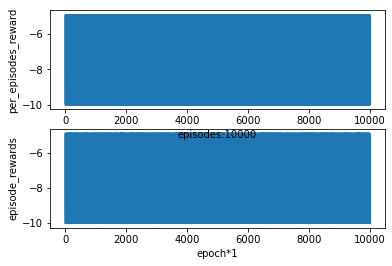

In [9]:
win_rates = []
episode_rewards = []
train_steps = 0
Per_episode_reward = []
s = FlatList()

for epoch in range(args.n_epoch):
    if epoch%1000 ==0:
        print('Run {}, train epoch {}'.format(1, epoch))

    if epoch % args.evaluate_cycle == 0:
        _, episode_reward, per_episodes_reward = evaluate()
#         win_rates.append(win_rate)
#         print(episode_reward)
        episode_rewards.append(episode_reward)
        Per_episode_reward.append(per_episodes_reward)

#         plt.cla()
#         plt.subplot(2, 1, 1)
#         plt.plot(range(len(Per_episode_reward)), Per_episode_reward)
#         plt.xlabel('episodes:{}'.format(len(Per_episode_reward)))
#         plt.ylabel('per_episodes_reward')

        plt.subplot(2, 1, 2)
        plt.plot(range(len(episode_rewards)), episode_rewards)
        plt.xlabel('epoch*{}'.format(args.evaluate_cycle))
        plt.ylabel('episode_rewards')

#         plt.savefig(save_path + '/plt_{}.png'.format(1), format='png')
#         np.save(save_path + '/win_rates_{}'.format(1), win_rates)
#         np.save(save_path + '/episode_rewards_{}'.format(1), episode_rewards)

    episodes = []
    for episode_idx in range(args.n_episodes):
        episode, _ = worker.generate_episode(episode_idx)
        episodes.append(episode)
    episode_batch = episodes[0]
    episodes.pop(0)
    for episode in episodes:
        for key in episode_batch.keys():
            episode_batch[key] = np.concatenate((episode_batch[key], episode[key]), axis=0)


        buffer.store_episode(episode_batch)
        for train_step in range(args.train_steps):
#             print(buffer.current_size)
#             print(args.batch_size)
            mini_batch = buffer.sample(min(buffer.current_size, args.batch_size))
#             print(mini_batch)
            agents.train(mini_batch, train_steps)
            train_steps += 1
# plt.cla()
# plt.subplot(2, 1, 1)
# plt.plot(range(len(win_rates)), win_rates)
# plt.xlabel('epoch*{}'.format(args.evaluate_cycle))
# plt.ylabel('win_rate')

# print(per_episodes_reward)
s.run(big_list=Per_episode_reward)
Per_episode_reward = s.res
plt.cla()
plt.subplot(2, 1, 1)
plt.plot(range(len(Per_episode_reward)), Per_episode_reward)
plt.xlabel('episodes:{}'.format(len(Per_episode_reward)))
plt.ylabel('per_episodes_reward')

plt.subplot(2, 1, 2)
plt.plot(range(len(episode_rewards)), episode_rewards)
plt.xlabel('epoch*{}'.format(args.evaluate_cycle))
plt.ylabel('episode_rewards')           

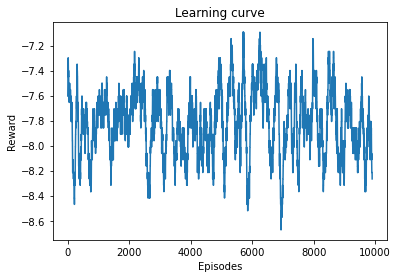

In [10]:
def moving_average(x, N):
    return np.convolve(x, np.ones((N,)) / N, mode='valid')

plt.plot(moving_average(episode_rewards, 100))
plt.title('Learning curve')
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.show()

In [12]:
import os

def text_save(filename, data):#filename为写入CSV文件的路径，data为要写入数据列表.
    file = open(filename,'a')
    for i in range(len(data)):
        s = str(data[i]).replace('[','').replace(']','')#去除[],这两行按数据不同，可以选择
        s = s.replace("'",'').replace(',','') +'\n'   #去除单引号，逗号，每行末尾追加换行符
        file.write(s)
    file.close()
    print("保存文件成功") 
# with open('test.txt','a') as file0:
#     print('%d' % episode_reward,file=file0)

text_save("test", episode_rewards)

保存文件成功


In [15]:
moving_average(episode_rewards, 100)
text_save("1", moving_average(episode_rewards, 100))

保存文件成功
